In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [3]:
mapping = {'FF' : 0,
           'SL': 1, 
           'CU': 2, 
           'SI': 3, 
           'FC': 4, 
           'FT': 5, 
           'KC': 6, 
           'CH': 7, 
           'KN': 8, 
           'FS': 9, 
           'FO': 10, 
           'EP': 11, 
           'SC': 12}

In [16]:
dataset = pd.read_pickle("data/advanced_dataset_final.pkl")

train_index_stop = 569484 # this is the first index of a new pitcher
val_index_stop = 640690 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

train_X = training_set.drop(["uid", "pitch_type", "type_confidence"],axis=1)
train_y = training_set['pitch_type']
train_weights = training_set['type_confidence']

val_X = validation_set.drop(["uid", "pitch_type", "type_confidence"],axis=1)
val_y = validation_set['pitch_type']
val_weights = validation_set['type_confidence']

test_X = test_set.drop(["uid", "pitch_type", "type_confidence"],axis=1)
test_y = test_set['pitch_type']
test_weights = test_set['type_confidence']

train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [17]:
model_path_name = "weighted_adv_feat_no_pitcher_id"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"
clf = pickle.load(open(f"{DIRECTORY_PATH}/xgb_model.pkl", "rb"))


In [19]:

y_test_pred = clf.predict(test_X.drop(['pitcher_id'],axis=1))


In [20]:
print('\n------------------ TEST DATA Confusion Matrix -----------------\n')
test_cmatrix = confusion_matrix(test_y, y_test_pred)
print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")



------------------ TEST DATA Confusion Matrix -----------------

       FF    SL    CU    SI    FC    FT   KC    CH   KN   FS  FO  EP  SC
FF  17308  2625   814   551   579  1468   86   919   51  148   3   0   0
SL   4308  4543   245   561    90   611    4   248    0   83   1   0   3
CU   2225   489  1499   229   422   713    4   319   12   40   0   0   0
SI    919  1707   433  3258   474    21   28   850    0  154   0   0   0
FC   1489   229   360   185  1623   263   30   272    0    8   0   0   0
FT   2692   919   444    28   137  3535   16   410    0   27   0   0   1
KC    395    19     0   111    21    43  186   103    0    0   0   0   0
CH   2992   576   362   476   336   742   59  1621    0   12   0   0   0
KN     12     0     0     0     0     0    0     0  293    0   0   1   0
FS    427    78    38    57    41    94    0    16    0  279   0   0   0
FO      8     0     0     0     0     1    0     0    0    0  11   0   0
EP      3     0     1     0     0     0    0     0    9   

In [21]:

print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())))


              precision    recall  f1-score   support

          FF       0.53      0.70      0.60     24552
          SL       0.41      0.42      0.42     10697
          CU       0.36      0.25      0.30      5952
          SI       0.60      0.42      0.49      7844
          FC       0.44      0.36      0.40      4459
          FT       0.47      0.43      0.45      8209
          KC       0.45      0.21      0.29       878
          CH       0.34      0.23      0.27      7176
          KN       0.80      0.96      0.87       306
          FS       0.37      0.27      0.31      1030
          FO       0.73      0.55      0.63        20
          EP       0.50      0.07      0.12        14
          SC       0.43      0.21      0.29        14

    accuracy                           0.48     71151
   macro avg       0.49      0.39      0.42     71151
weighted avg       0.47      0.48      0.47     71151



In [29]:
#test_X.query("pitcher_id == 448252").drop(['pitcher_id'],axis=1)

In [38]:
def view_pitcher_results(pitcher_id, training_set, validation_set, filepath=None):
    pid = pitcher_id
    num_in_training = training_set.query("pitcher_id == @pid").shape[0]
    num_in_validation = validation_set.query("pitcher_id == @pid").shape[0]

    training_pitch_type_rates = training_set.query("pitcher_id == @pid").pitch_type.value_counts(normalize=True)
    #validation_pitch_type_rates = training_set.query("pitcher_id == @pid").pitch_type.value_counts(normalize=True)

    predictions = clf.predict(validation_set.query("pitcher_id == @pid").drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1))
    true_vals = validation_set.query("pitcher_id == @pid")['pitch_type'].map(mapping)
    pitcher_confusion_matrix = confusion_matrix(true_vals, predictions, labels=list(mapping.values()))

    print(f"Num instances of pitcher {pid} in training set = {num_in_training}")
    print(f"Num instances of pitcher {pid} in test set = {num_in_validation}")
    print(f"Training rates = \n {pd.DataFrame(training_pitch_type_rates).T} ")

    print(f"Confusion matrix for Pitcher {pid} :")
    print(f"{pd.DataFrame(pitcher_confusion_matrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
    print(f"Classification Report : ")
    print(classification_report(true_vals, predictions, zero_division=np.nan))
    if filepath is not None:
        with open(filepath, "a") as text_file:
            print(f'\n------------------ Pitcher {pid}: -----------------\n', file=text_file)
            print(f"Training n = {num_in_training}", file=text_file)
            print(f"Test n = {num_in_validation}", file=text_file)
            print(f"Training rates = \n {pd.DataFrame(training_pitch_type_rates).T} ", file=text_file)

            print(f"Confusion matrix for Pitcher {pid} :", file=text_file)
            print(f"{pd.DataFrame(pitcher_confusion_matrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
            print(f"Classification Report : ", file=text_file)
            print(classification_report(true_vals, predictions, zero_division=np.nan), file=text_file)
    

In [34]:
view_pitcher_results(407819, training_set, test_set)
view_pitcher_results(407819, training_set, test_set, MODEL_INFO_FILEPATH)

Num instances of pitcher 407819 in training set = 819
Num instances of pitcher 407819 in test set = 99
Training rates = 
 pitch_type        FF        FC        FT        SL   CH   CU   EP   FO   FS  \
proportion  0.849817  0.096459  0.026862  0.026862  0.0  0.0  0.0  0.0  0.0   

pitch_type   KC   KN   SC   SI  
proportion  0.0  0.0  0.0  0.0   
Confusion matrix for Pitcher 407819 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF  79   0   0   0   0   0   0   0   0   0   0   0   0
SL  13   0   0   0   0   0   0   0   0   0   0   0   0
CU   0   0   0   0   0   0   0   0   0   0   0   0   0
SI   0   0   0   0   0   0   0   0   0   0   0   0   0
FC   1   0   0   0   0   0   0   0   0   0   0   0   0
FT   6   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   0   0   0   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0   0   0
FO   0   

In [35]:
# does well in case where little diversity
view_pitcher_results(547973, training_set, test_set)
view_pitcher_results(547973, training_set, test_set, MODEL_INFO_FILEPATH)

Num instances of pitcher 547973 in training set = 661
Num instances of pitcher 547973 in test set = 109
Training rates = 
 pitch_type       FF        SL        CH   CU   EP   FC   FO   FS   FT   KC  \
proportion  0.83056  0.163389  0.006051  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

pitch_type   KN   SC   SI  
proportion  0.0  0.0  0.0   
Confusion matrix for Pitcher 547973 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF  95   1   0   0   0   0   0   0   0   0   0   0   0
SL  10   2   0   0   0   0   0   0   0   0   0   0   0
CU   0   0   0   0   0   0   0   0   0   0   0   0   0
SI   0   0   0   0   0   0   0   0   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   1   0   0   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0   0   0
FO   0   0   0   0  

In [37]:
# view pitcher with no four seam
view_pitcher_results(599899, training_set, test_set)
view_pitcher_results(599899, training_set, test_set, MODEL_INFO_FILEPATH)


Num instances of pitcher 599899 in training set = 637
Num instances of pitcher 599899 in test set = 41
Training rates = 
 pitch_type        SI        CU        SC        SL        CH   EP   FC   FF  \
proportion  0.547881  0.295133  0.076923  0.051805  0.028257  0.0  0.0  0.0   

pitch_type   FO   FS   FT   KC   KN  
proportion  0.0  0.0  0.0  0.0  0.0   
Confusion matrix for Pitcher 599899 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF   0   0   0   0   0   0   0   0   0   0   0   0   0
SL   0   1   1   0   0   0   0   1   0   0   0   0   0
CU   0   1  11   0   0   0   0   0   0   0   0   0   0
SI   0   3  19   2   0   0   0   0   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   0   1   0   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0   0   0

In [55]:
pitcher_id = 599899
predictions = clf.predict(test_set.query("pitcher_id == @pitcher_id").drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1))
examples = test_set.query("pitcher_id == @pitcher_id").copy(deep=True)
examples['preds'] = predictions
examples = examples[['preds'] + list(examples.columns)[0:-1]]

In [58]:
mapping

{'FF': 0,
 'SL': 1,
 'CU': 2,
 'SI': 3,
 'FC': 4,
 'FT': 5,
 'KC': 6,
 'CH': 7,
 'KN': 8,
 'FS': 9,
 'FO': 10,
 'EP': 11,
 'SC': 12}

In [57]:
examples

,preds,uid,pitch_type,type_confidence,inning,top,score_diff,at_bat_num,p_throws,pcount_pitcher,bases_state,pitcher_id,pcount_at_bat,balls,strikes,outs,stand,height_inches,prev_pitch_type,prev_type,prev_end_speed,prev_break_length,prev_break_angle,prev_break_y,prev_zone,prev_spin_dir,prev_spin_rate,prev_5_CH_%,prev_5_CU_%,prev_5_EP_%,prev_5_FC_%,prev_5_FF_%,prev_5_FO_%,prev_5_FS_%,prev_5_FT_%,prev_5_KC_%,prev_5_KN_%,prev_5_SC_%,prev_5_SI_%,prev_5_SL_%,prev_10_CH_%,prev_10_CU_%,prev_10_EP_%,prev_10_FC_%,prev_10_FF_%,prev_10_FO_%,prev_10_FS_%,prev_10_FT_%,prev_10_KC_%,prev_10_KN_%,prev_10_SC_%,prev_10_SI_%,prev_10_SL_%,prev_20_CH_%,prev_20_CU_%,prev_20_EP_%,prev_20_FC_%,prev_20_FF_%,prev_20_FO_%,prev_20_FS_%,prev_20_FT_%,prev_20_KC_%,prev_20_KN_%,prev_20_SC_%,prev_20_SI_%,prev_20_SL_%,prev_5_B_%,prev_5_S_%,prev_5_X_%,prev_10_B_%,prev_10_S_%,prev_10_X_%,prev_20_B_%,prev_20_S_%,prev_20_X_%,historical_CH_%,historical_CU_%,historical_EP_%,historical_FC_%,historical_FF_%,historical_FO_%,historical_FS_%,historical_FT_%,historical_KC_%,historical_KN_%,historical_SC_%,historical_SI_%,historical_SL_%,pit_v_bat_CH_%,pit_v_bat_CU_%,pit_v_bat_EP_%,pit_v_bat_FC_%,pit_v_bat_FF_%,pit_v_bat_FO_%,pit_v_bat_FS_%,pit_v_bat_FT_%,pit_v_bat_KC_%,pit_v_bat_KN_%,pit_v_bat_SC_%,pit_v_bat_SI_%,pit_v_bat_SL_%,historical_batter_B_%,historical_batter_S_%,historical_batter_X_%
711800,2,19659122,SI,0.000,7,True,5,57,R,1,000,599899,1,0,0,0,L,71,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.10,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.55,0.10,0.2,0.4,0.4,0.3,0.3,0.4,0.50,0.25,0.25,0.030391,0.302460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073806,0.535456,0.057887,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.333333,0.333333,0.351036,0.443653,0.205311
711801,2,19659123,SI,0.000,7,True,5,57,R,2,000,599899,2,0,1,0,L,71,SI,L,78.6,7.8,20.4,23.8,1.0,256.826,1466.608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.10,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.60,0.10,0.2,0.6,0.2,0.3,0.4,0.3,0.45,0.30,0.25,0.030347,0.302023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073699,0.536127,0.057803,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.428571,0.285714,0.350356,0.444085,0.205559
711802,7,19659124,SL,0.851,7,True,5,57,R,3,000,599899,3,1,1,0,L,71,SI,L,79.9,8.7,18.2,23.8,11.0,278.456,1390.319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.10,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.65,0.05,0.2,0.6,0.2,0.3,0.4,0.3,0.45,0.30,0.25,0.030303,0.301587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073593,0.536797,0.057720,0.000000,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.500000,0.250000,0.350549,0.444158,0.205294
711803,2,19659125,SC,0.902,7,True,5,57,R,4,000,599899,4,1,2,0,L,71,SL,L,68.7,12.8,1.0,23.9,11.0,349.188,871.943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.1,0.10,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.65,0.05,0.2,0.6,0.2,0.3,0.5,0.2,0.45,0.30,0.25,0.030259,0.301153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073487,0.536023,0.059078,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.444444,0.333333,0.350097,0.444874,0.205029
711804,2,19659126,CU,0.889,7,True,5,58,R,5,000,599899,1,0,0,1,L,70,NaN,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.7,0.1,0.10,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.60,0.05,0.2,0.6,0.2,0.2,0.6,0.2,0.40,0.35,0.25,0.030216,0.300719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074820,0.535252,0.058993,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.500000,0.500000,0.331439,0.517045,0.151515
711805,2,19659127,CU,0.881,7,True,5,58,R,6,000,599899,2,1,0,1,L,70,CU,L,65.4,14.0,-19.9,23.9,11.0,73.868,1880.393,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,0.2,0.1,0.1,0.0,0.0,0.0,0.0

In [62]:
model_path_name = "adv_feat_no_pitcher_id"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"
clf = pickle.load(open(f"{DIRECTORY_PATH}/xgb_model.pkl", "rb"))

In [64]:
y_test_pred = clf.predict(test_X.drop(['pitcher_id'],axis=1))
print('\n------------------ TEST DATA Confusion Matrix -----------------\n')
test_cmatrix = confusion_matrix(test_y, y_test_pred)
print(f"{pd.DataFrame(test_cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")



------------------ TEST DATA Confusion Matrix -----------------

       FF    SL    CU    SI    FC    FT   KC   CH   KN   FS  FO  EP  SC
FF  18261  1961   491  1065   457  1572   73  509   50  111   2   0   0
SL   4741  3435   138  1425    99   696    6  108    0   48   1   0   0
CU   2600   335  1033   634   387   736    3  179   12   33   0   0   0
SI    554   490   104  6200   270    23   19  144    0   40   0   0   0
FC   1651   184   225   341  1572   296   29  153    0    8   0   0   0
FT   2956   714   356    38   102  3750   12  252    0   28   0   0   1
KC    414    18     0   114    20    63  167   82    0    0   0   0   0
CH   3386   393   206  1070   322   838   59  890    0   12   0   0   0
KN     10     0     0     0     0     0    0    0  294    0   0   2   0
FS    435    46    21   172    43    99    0    2    0  212   0   0   0
FO     11     0     0     0     0     0    0    0    0    0   9   0   0
EP      2     1     1     0     0     0    0    0    9    0   0   1   

In [93]:
print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())))

NameError: name 'sklearn' is not defined

In [66]:
view_pitcher_results(599899, training_set, test_set, MODEL_INFO_FILEPATH)

Num instances of pitcher 599899 in training set = 637
Num instances of pitcher 599899 in test set = 41
Training rates = 
 pitch_type        SI        CU        SC        SL        CH   EP   FC   FF  \
proportion  0.547881  0.295133  0.076923  0.051805  0.028257  0.0  0.0  0.0   

pitch_type   FO   FS   FT   KC   KN  
proportion  0.0  0.0  0.0  0.0  0.0   
Confusion matrix for Pitcher 599899 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF   0   0   0   0   0   0   0   0   0   0   0   0   0
SL   0   0   0   3   0   0   0   0   0   0   0   0   0
CU   0   0   1  11   0   0   0   0   0   0   0   0   0
SI   0   0   2  22   0   0   0   0   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   0   0   1   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0   0   0

In [95]:
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [115]:
dataset = pd.read_pickle("data/advanced_dataset_final.pkl")

train_index_stop = 569484 # this is the first index of a new pitcher
val_index_stop = 640690 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

test_X = test_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1)
test_y = test_set['pitch_type']
test_weights = test_set['type_confidence']

test_y = test_y.map(mapping)

model_path_name = "adv_feat_no_pitcher_id"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"
clf = pickle.load(open(f"{DIRECTORY_PATH}/xgb_model.pkl", "rb"))
y_test_pred = clf.predict(test_X)


In [109]:
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    #print(f"##### TEST CLASSIFICATION REPORT #####", file=text_file)
    print(f"Accuracy = {accuracy_score(test_y, y_test_pred)}", file=text_file)
    #print(classification_report(test_y, y_test_pred, target_names=list(mapping.keys())), file=text_file)


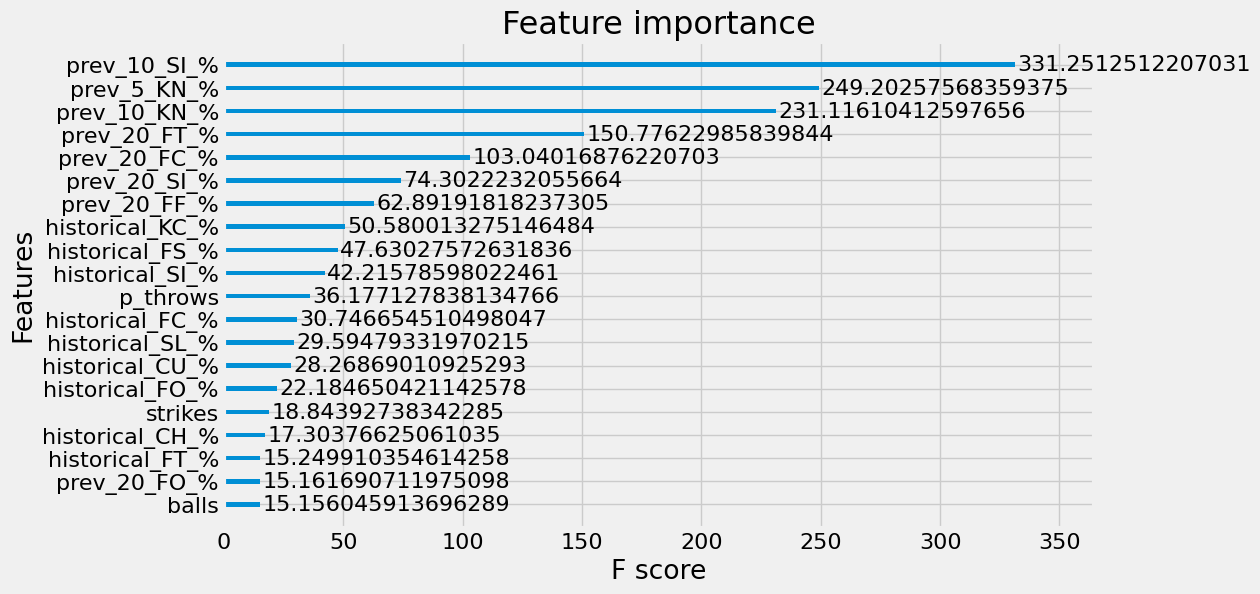

In [116]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.savefig(f"{DIRECTORY_PATH}/feature_importance.png", bbox_inches = 'tight')
plt.show()